In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset and perform preprocessing.

    Inputs:
    -num_training: number of training examples
    -num_validation: number of validation examples
    -num_test: number of test examples

    Output:
    a dictionary with keys 'X_train', 'y_train', 'X_val', 'y_val', 'X_test' and
    'y_test'
    """
    # Load the CIFAR-10 dataset and change data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10

    # Subsample the data
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    
    # Normalize the data over the channels by subtracting the mean pixel and dividing std 
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test
    }

In [3]:
data = load_cifar10()

for k, v in data.items():
  print('%s: ' % k, v.shape, v.dtype)

170500096/170498071 [==============================] - 4s 0us/step
X_train:  (49000, 32, 32, 3) float64
y_train:  (49000, 1) uint8
X_val:  (1000, 32, 32, 3) float64
y_val:  (1000, 1) uint8
X_test:  (10000, 32, 32, 3) float64
y_test:  (10000, 1) uint8


In [0]:
def conv_bn_relu(X, num_filters, filter_size=3, stride=1, pad='same'):
  regularizer = tf.keras.regularizers.l2(1e-3)

  X = tf.keras.layers.Conv2D(num_filters, filter_size, stride, pad, kernel_regularizer=regularizer)(X)
  X = tf.keras.layers.BatchNormalization()(X)
  X = tf.keras.layers.Activation('relu')(X)
  return X

In [0]:
def CustomConvNet(input_shape=(32,32,3), num_classes=10, reg=1e-1):
  filters = [32, 64, 128]
  regularizer = tf.keras.regularizers.l2(reg)

  X_input = tf.keras.Input(input_shape)

  X = tf.keras.layers.ZeroPadding2D(padding=1)(X_input)

  # stage 1
  X = conv_bn_relu(X, filters[0])
  X = conv_bn_relu(X, filters[0])
  X = tf.keras.layers.MaxPool2D(3,2)(X)

  # stage 2
  X = conv_bn_relu(X, filters[1])
  X = conv_bn_relu(X, filters[1])
  X = conv_bn_relu(X, filters[1])
  X = tf.keras.layers.MaxPool2D(3,2)(X)

  # stage 3
  X = conv_bn_relu(X, filters[2])
  X = conv_bn_relu(X, filters[2])
  X = conv_bn_relu(X, filters[2])
  X = tf.keras.layers.MaxPool2D(3,2)(X)
  
  # stage 4
  X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.Dense(300, kernel_regularizer=regularizer)(X)
  X = tf.keras.layers.Dense(100, kernel_regularizer=regularizer)(X)
  X = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=regularizer)(X)

  model = tf.keras.Model(X_input, X)

  return model

In [6]:
model = CustomConvNet()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 34, 34, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 34, 34, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 34, 34, 32)        128   

In [7]:
lr = 1e-3

model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

history = model.fit(data['X_train'], data['y_train'], batch_size=64, epochs=10,
                    validation_data=(data['X_val'], data['y_val']))

Epoch 1/10
766/766 [==============================] - 23s 30ms/step - loss: 9.8906 - acc: 0.4246 - val_loss: 2.0352 - val_acc: 0.5530
Epoch 2/10
766/766 [==============================] - 22s 29ms/step - loss: 1.6713 - acc: 0.6200 - val_loss: 1.6594 - val_acc: 0.6010
Epoch 3/10
766/766 [==============================] - 22s 29ms/step - loss: 1.3991 - acc: 0.6860 - val_loss: 1.5087 - val_acc: 0.6120
Epoch 4/10
766/766 [==============================] - 22s 29ms/step - loss: 1.2761 - acc: 0.7249 - val_loss: 1.8432 - val_acc: 0.5570
Epoch 5/10
766/766 [==============================] - 22s 29ms/step - loss: 1.2087 - acc: 0.7486 - val_loss: 1.2833 - val_acc: 0.7350
Epoch 6/10
766/766 [==============================] - 22s 29ms/step - loss: 1.1614 - acc: 0.7725 - val_loss: 1.3768 - val_acc: 0.6870
Epoch 7/10
766/766 [==============================] - 22s 29ms/step - loss: 1.1204 - acc: 0.7890 - val_loss: 1.2821 - val_acc: 0.7310
Epoch 8/10
766/766 [==============================] - 22s 29ms

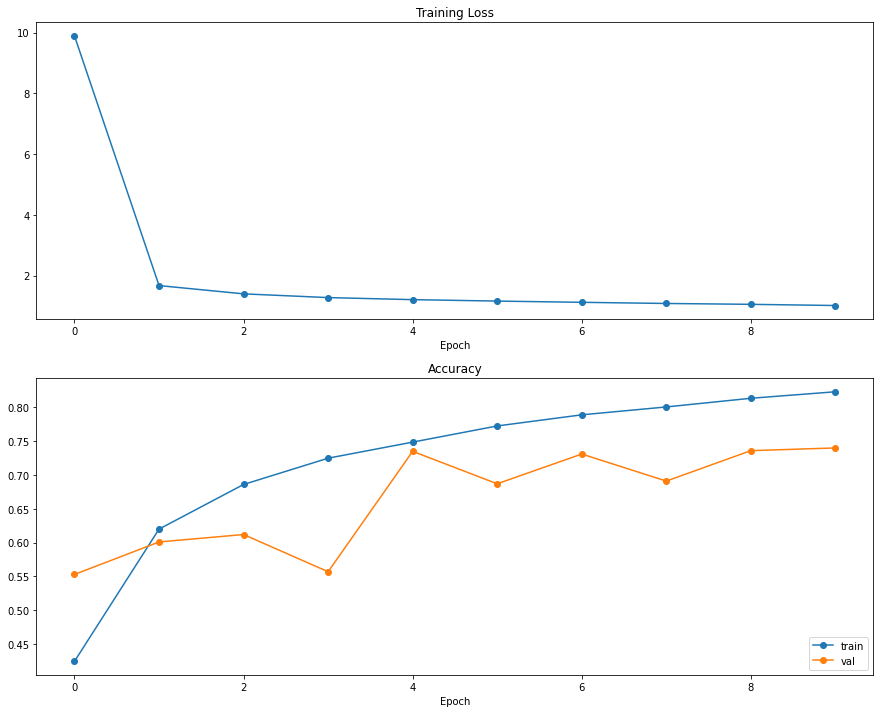

In [8]:
plt.subplot(2, 1, 1)
plt.title('Training Loss')
plt.plot(history.history['loss'], '-o')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(history.history['acc'], '-o', label='train')
plt.plot(history.history['val_acc'], '-o', label='val')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

In [9]:
model.evaluate(data['X_test'], data['y_test'])

313/313 [==============================] - 2s 7ms/step - loss: 1.2737 - acc: 0.7386


[1.2736510038375854, 0.7386000156402588]